# LiDAR Sensor Data Acqusition

## 0. Import Library

In [98]:
import serial
import time
import struct
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# For debugging/testing in Jupyter
from IPython.display import clear_output

## 1. Utility Functions

In [99]:
def list_available_ports():
    """List all available serial ports for debugging."""
    import serial.tools.list_ports
    
    ports = serial.tools.list_ports.comports()
    
    if not ports:
        print("No serial ports found.")
        return []
    
    print("Available serial ports:")
    for port in ports:
        print(f"- {port.device}: {port.description}")
    
    return [port.device for port in ports]

def debug_serial_connection(port, baudrate=115200, timeout=1, read_bytes=20):
    """Test reading raw bytes from a serial port for debugging."""
    try:
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print(f"Connected to {port}")
        
        # Try to read some raw bytes
        print(f"Reading {read_bytes} raw bytes...")
        data = ser.read(read_bytes)
        
        print(f"Read {len(data)} bytes:")
        print("Hex: ", ' '.join(f'{b:02x}' for b in data))
        print("Dec: ", data)
        
        ser.close()
        print("Connection closed")
        
    except serial.SerialException as e:
        print(f"Error connecting to {port}: {e}")

def analyze_packet_structure(port, baudrate=115200, timeout=1, num_packets=1):
    """Analyze multiple raw packets to help understand their structure for P8864-SMD-B15 sensor."""
    try:
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print(f"Connected to {port}")
        
        packets = []
        start_time = time.time()
        
        # Try to collect some packets
        print(f"Collecting {num_packets} raw response segments...")
        
        # First send power-on command to make sure the sensor is ready
        # Command format: 0xF5 + 0x40 + [0x01] + [0x00]*7 + 4 CRC bytes
        cmd = bytearray([0xF5, 0x40, 0x01])
        cmd.extend([0x00] * 7)  # 7 more zero bytes for parameters
        cmd.extend([0x9C, 0xD7, 0xD6, 0x91])  # CRC value from manual example
        
        print("Sending power-on command: " + ' '.join(f'{b:02x}' for b in cmd))
        ser.write(cmd)
        
        # Wait for response - datasheet says tPROC < 200ms
        time.sleep(0.2)
        
        # Read the power-on response
        power_response = ser.read(8)  # Read enough to capture response
        if len(power_response) == 8:
            print("Power-on response: " + ' '.join(f'{b:02x}' for b in power_response))
            
            # Validate response
            if (power_response[0] == 0xFA and 
                power_response[1] == 0x00 and
                power_response[2] == 0x00 and 
                power_response[3] == 0x00):
                print("✓ LiDAR POWER ON SUCCESSFUL")
            else:
                print("✗ LiDAR POWER ON FAILED - Unexpected response format")
        else:
            print(f"✗ LiDAR POWER ON FAILED - Got {len(power_response)} bytes instead of 8")
        
        # Send distance command a few times
        for i in range(num_packets):
            # Command format: 0xF5 + 0x29 + [0x00]*8 + 4 CRC bytes
            cmd = bytearray([0xF5, 0x29])
            cmd.extend([0x00] * 8)  # 8 zero bytes for parameters
            
            # CRC value from manual example
            cmd.extend([0xCB, 0xFA, 0xAB, 0xE7])
            
            print(f"\nSending distance command {i+1}/{num_packets}: " + ' '.join(f'{b:02x}' for b in cmd))
            ser.write(cmd)
            
            # According to manual, response time tPROC < 25ms
            time.sleep(0.03)  # 30ms to be safe

            header = ser.read(4) # Read the first 4 bytes for header: fa 0b 00 02
            
            if len(header) == 4 and header[0] == 0xFA and header[1] == 0x0B:
                # Valid header found, now get the data length
                data_length = header[2] | (header[3] << 8)
                
                print(f"✓ Valid GET_DISTANCE response header: 0xFA 0x0B")
                print(f"✓ Data length: {data_length} bytes")
                
                # For an 8x8 sensor with 64 pixels, we expect:
                # - Each pixel has 4 bytes for distance and 4 bytes for amplitude
                # - Total: 64 pixels × (4+4) bytes = 512 bytes
                if data_length == 512:
                    print(f"✓ Data length matches expected 8x8 sensor (512 bytes)")
                else:
                    print(f"! Unexpected data length: {data_length}, expected 512 for 8x8 sensor")
                
                # Now read the actual data + CRC (4 bytes)
                data_with_crc = ser.read(data_length + 4)
                
                if len(data_with_crc) == data_length + 4:
                    print(f"✓ Successfully read complete response ({data_length + 4} bytes)")
                    
                    # Combine header and data for full packet
                    full_packet = header + data_with_crc
                    packets.append(full_packet)
                    
                    # Display a preview of the data (first few bytes)
                    preview_length = min(20, data_length)
                    print(f"Data preview: " + ' '.join(f'{b:02x}' for b in data_with_crc[:preview_length]) + "...")
                    
                    # Validate CRC if needed (optional advanced validation)
                    # This would require implementing the full CRC32 calculation
                    
                    # Extract and display the first pixel's distance value
                    if data_length >= 4:
                        distance_raw = int.from_bytes(data_with_crc[0:4], byteorder='little')
                        
                        # Check for error codes as per manual
                        if 16001000 <= distance_raw <= 16006000:
                            error_codes = {
                                16001000: "TOF weak amplitude",
                                16002000: "Overflow",
                                16003000: "Saturation",
                                16004000: "Reserved",
                                16005000: "Insufficient flow",
                                16006000: "TOF high amplitude"
                            }
                            print(f"! First pixel reports error: {error_codes.get(distance_raw, 'Unknown error')}")
                        else:
                            # Convert from 0.1mm to cm (as per manual)
                            distance_cm = distance_raw / 100.0
                            print(f"✓ First pixel distance: {distance_cm:.2f} cm")
                    
                    # Extract and display the first pixel's amplitude value
                    if data_length >= 256 + 4:  # Amplitudes start after all distances
                        amplitude = int.from_bytes(data_with_crc[256:260], byteorder='little')
                        print(f"✓ First pixel amplitude: {amplitude}")
                        
                        # Validate amplitude quality according to manual
                        if amplitude < 100:
                            print(f"! Low amplitude (<100): Distance may have significant noise")
                        elif amplitude > 1900:
                            print(f"! High amplitude (>1900): Distance may contain significant errors")
                        else:
                            print(f"✓ Good amplitude (100-1900): Distance should be reliable")
                else:
                    print(f"✗ Incomplete data: Expected {data_length + 4} bytes, received {len(data_with_crc)}")
            else:
                # Invalid or missing header
                if len(header) == 0:
                    print("✗ No response received")
                elif len(header) < 4:
                    print(f"✗ Incomplete header: {' '.join(f'{b:02x}' for b in header)}")
                else:
                    print(f"✗ Invalid header: {' '.join(f'{b:02x}' for b in header)}")
                
                # Try to read any additional bytes that might be available
                additional_data = ser.read(100)
                if additional_data:
                    print(f"Additional data received ({len(additional_data)} bytes): " + 
                        ' '.join(f'{b:02x}' for b in additional_data[:50]) + 
                        ("..." if len(additional_data) > 50 else ""))
                    
                    # Save whatever we got for analysis
                    packets.append(header + additional_data)
        
        ser.close()
        print("Connection closed")
        
        # Analyze the collected data
        if packets:
            print("\nAnalyzing collected responses:")
            
            for i, packet in enumerate(packets):
                print(f"\nResponse {i+1} ({len(packet)} bytes):")
                
                # Look for response header 0xFA
                header_indices = []
                for j in range(len(packet)):
                    if packet[j] == 0xFA:
                        header_indices.append(j)
                
                if header_indices:
                    print(f"Potential response headers (0xFA) found at indices: {header_indices}")
                    
                    # For each potential header, try to interpret as LiDAR response
                    for idx in header_indices:
                        if idx + 4 <= len(packet):  # Need at least header + type + length
                            # Extract header values
                            header_byte = packet[idx]
                            response_type = packet[idx+1]
                            data_length = packet[idx+2] | (packet[idx+3] << 8) if idx+3 < len(packet) else 0
                            
                            print(f"  Response at index {idx}:")
                            print(f"    Header: 0x{header_byte:02x}")
                            print(f"    Type: 0x{response_type:02x}")
                            print(f"    Data Length: {data_length} bytes")
                            
                            # Check if we have enough data for the complete response
                            total_expected = idx + 4 + data_length + 4  # header + type + length + data + CRC
                            
                            if total_expected <= len(packet):
                                if response_type == 0x0B:  # Distance and amplitude data
                                    print(f"    Response Type: Distance and Amplitude Data")
                                    
                                    # For a demo, just decode the first pixel's distance and amplitude
                                    if data_length >= 8:
                                        # Distance is first 4 bytes (little endian)
                                        distance_bytes = packet[idx+4:idx+8]
                                        distance_raw = int.from_bytes(distance_bytes, byteorder='little')
                                        
                                        # Check for specific error codes
                                        if 16001000 <= distance_raw <= 16006000:
                                            print(f"    First pixel has error code: {distance_raw}")
                                        else:
                                            # Convert from 0.1mm to cm
                                            distance_cm = distance_raw / 100.0
                                            print(f"    First pixel distance: {distance_cm:.2f} cm")
                                            
                                        # For simplicity, we're just checking amplitude of first pixel
                                        # In reality, we'd need to know array dimensions to find correct offset
                                        if data_length >= 264:  # 256 + 8 for first amplitude
                                            amplitude_bytes = packet[idx+4+256:idx+4+260]
                                            amplitude = int.from_bytes(amplitude_bytes, byteorder='little')
                                            print(f"    First pixel amplitude: {amplitude}")
                                elif response_type == 0x00:  # Acknowledge
                                    print(f"    Response Type: Command Acknowledgement")
                                else:
                                    print(f"    Response Type: Other (0x{response_type:02x})")
                            else:
                                print(f"    Incomplete response: Expected {total_expected} bytes, got {len(packet)}")
                else:
                    print("No valid response headers found")
        else:
            print("No data collected")
            
    except serial.SerialException as e:
        print(f"Error connecting to {port}: {e}")

## 2. Connect to Sensor and Read Data from the Sensor

In [100]:
list_available_ports()

Available serial ports:
- COM6: Standard Serial over Bluetooth link (COM6)
- COM3: Standard Serial over Bluetooth link (COM3)
- COM4: Silicon Labs CP210x USB to UART Bridge (COM4)


['COM6', 'COM3', 'COM4']

In [101]:
debug_serial_connection('COM4', baudrate=115200, timeout=1, read_bytes=50)

Connected to COM4
Reading 50 raw bytes...
Read 0 bytes:
Hex:  
Dec:  b''
Connection closed


In [113]:
analyze_packet_structure('COM4')

Connected to COM4
Sending power-on command: f5 40 01 00 00 00 00 00 00 00 9c d7 d6 91
Power-on response: fa 00 00 00 b2 ab fc e8
✓ LiDAR POWER ON SUCCESSFUL

Sending distance command 1/1: f5 29 00 00 00 00 00 00 00 00 cb fa ab e7
✓ Valid GET_DISTANCE response header: 0xFA 0x0B
✓ Data length: 512 bytes
✓ Data length matches expected 8x8 sensor (512 bytes)
✓ Successfully read complete response (516 bytes)
Data preview: e3 0a 00 00 cb 0d 00 00 9d 0d 00 00 53 0f 00 00 f2 0f 00 00...
✓ First pixel distance: 27.87 cm
✓ First pixel amplitude: 1443
✓ Good amplitude (100-1900): Distance should be reliable
Connection closed

Analyzing collected responses:

Response 1 (520 bytes):
Potential response headers (0xFA) found at indices: [0, 312]
  Response at index 0:
    Header: 0xfa
    Type: 0x0b
    Data Length: 512 bytes
    Response Type: Distance and Amplitude Data
    First pixel distance: 27.87 cm
    First pixel amplitude: 1443
  Response at index 312:
    Header: 0xfa
    Type: 0x03
    Dat

## 3. Create `LiDARSensor` Object

In [131]:
class LiDARSensor:
    """Class to interface with P8864-SMD-B15 LiDAR sensor from SenkyLaser."""

    # Command IDs from the datasheet
    HEADER_BYTE = 0xF5  # Command header byte
    RESPONSE_BYTE = 0xFA  # Response header byte
    POWER_CMD = 0x40  # Power on/off command
    GET_DISTANCE_CMD = 0x29  # Get distance and amplitude command
    GET_REGION_SIZE_CMD = 0x57  # Get TOF sensor region length and width
    GET_TEMP_CMD = 0x4A  # Get temperature command
    GET_FIRMWARE_CMD = 0x49  # Get firmware version command
    SET_ADAPTIVE_INTEGRATION_CMD = 0x55  # Set adaptive integration time
    SET_PERIOD_FREQUENCY_CMD = 0x58  # Set period frequency
    SET_INTEGRATION_TIME_CMD = 0x00  # Set integration time

    def __init__(self, port='/dev/ttyUSB0', baudrate=115200, timeout=1):
        """Initialize the LiDAR sensor connection.
        
        Args:
            port (str): Serial port name (default: /dev/ttyUSB0 for Linux, 
                        for Windows use 'COMx' where x is the port number)
            baudrate (int): Baud rate for serial communication (default: 115200)
            timeout (float): Serial read timeout in seconds (default: 1)
        """
        self.ser = None
        self.port = port
        self.baudrate = baudrate
        self.timeout = timeout

    def connect(self):
        """Establish connection to the LiDAR sensor."""
        try:
            self.ser = serial.Serial(
                port=self.port,
                baudrate=self.baudrate,
                bytesize=serial.EIGHTBITS,
                parity=serial.PARITY_NONE,
                stopbits=serial.STOPBITS_ONE,
                timeout=self.timeout
            )
            
            if self.ser.is_open:
                print(f"Successfully connected to {self.port}")
                # Clear buffer
                self.ser.reset_input_buffer()
                
                # Power on the sensor - required before other commands will work
                print("Powering on the LiDAR sensor...")
                power_result = self.power_on()
                if not power_result:
                    print("Warning: Failed to power on LiDAR sensor")
                
                return True
            else:
                print(f"Failed to open serial port {self.port}")
                return False
                
        except serial.SerialException as e:
            print(f"Serial connection error: {e}")
            return False
        
    def disconnect(self):
        """Close the connection to the LiDAR sensor."""
        if self.ser and self.ser.is_open:
            self.ser.close()
            print("Disconnected from LiDAR sensor")

    def get_region_size(self):
        """Get the TOF sensor region length and width (pixels).
        
        Returns:
            tuple: (length, width) of the sensor region in pixels,
                  or None if reading failed
        """
        if not self.ser or not self.ser.is_open:
            print("Serial port not open")
            return None
        
        # Command format: 0xF5 + 0x57 + 8 parameter bytes + 4 CRC bytes
        cmd = bytearray([self.HEADER_BYTE, self.GET_REGION_SIZE_CMD])
        cmd.extend([0x00] * 8)  # 8 zero bytes for parameters
        
        # Calculate CRC for the first 10 bytes (header + command + 8 params)
        # For simplicity, using the CRC from manual example
        cmd.extend([0xD7, 0x7C, 0xB3, 0x05])
        
        # Send command
        self.ser.write(cmd)
        
        # Read response header: 0xFA + TYPE + LENGTH(2)
        header = self.ser.read(4)
        print(f"header: {header}")
        
        if len(header) < 4:
            print("Timeout or incomplete header received")
            return None
            
        if header[0] != self.RESPONSE_BYTE:
            print(f"Invalid response header: {header.hex()}")
            return None
            
        response_type = header[1]
        data_length = header[2] | (header[3] << 8)
      
        
        # According to manual, response type should be 0x0C and length should be 2 bytes
        if response_type != 0x0C:
            print(f"Unexpected response type: {response_type}, expected 0x0C")
            return None
            
        if data_length != 2:
            print(f"Unexpected data length: {data_length}, expected 2")
            return None
            
        # Read data and CRC
        data_and_crc = self.ser.read(data_length + 4)  # data + 4 bytes CRC
        if len(data_and_crc) < data_length + 4:
            print(f"Incomplete data: expected {data_length + 4}, got {len(data_and_crc)}")
            return None
            
        # Extract length and width
        length = data_and_crc[0]
        width = data_and_crc[1]
        
        print(f"Sensor region size: {length}x{width} pixels")
        return (length, width)

    def get_temperature(self):
        """Get the chip temperature during the last distance acquisition.
        
        Returns:
            float: Temperature in degrees Celsius,
                  or None if reading failed
        """
        if not self.ser or not self.ser.is_open:
            print("Serial port not open")
            return None
        
        # Command format: 0xF5 + 0x4A + 8 parameter bytes + 4 CRC bytes
        cmd = bytearray([self.HEADER_BYTE, self.GET_TEMP_CMD])
        cmd.extend([0x00] * 8)  # 8 zero bytes for parameters
        
        # Calculate CRC for the first 10 bytes (header + command + 8 params)
        # For simplicity, using the CRC from manual example
        cmd.extend([0x18, 0x41, 0xF5, 0xA4])
        
        # Send command
        self.ser.write(cmd)
        
        # Read response header: 0xFA + TYPE + LENGTH(2)
        header = self.ser.read(4)
        if len(header) < 4:
            print("Timeout or incomplete header received")
            return None
            
        if header[0] != self.RESPONSE_BYTE:
            print(f"Invalid response header: {header.hex()}")
            return None
            
        response_type = header[1]
        data_length = header[2] | (header[3] << 8)
        
        # According to manual, response type should be 0xFC and length should be 2 bytes
        if response_type != 0xFC:
            print(f"Unexpected response type: {response_type}, expected 0xFC")
            return None
            
        if data_length != 2:
            print(f"Unexpected data length: {data_length}, expected 2")
            return None
            
        # Read data and CRC
        data_and_crc = self.ser.read(data_length + 4)  # data + 4 bytes CRC
        if len(data_and_crc) < data_length + 4:
            print(f"Incomplete data: expected {data_length + 4}, got {len(data_and_crc)}")
            return None
            
        # Extract temperature value (2's complement signed 16-bit, in 0.01°C units)
        temp_raw = int.from_bytes(data_and_crc[0:2], byteorder='little', signed=True)
        temperature = temp_raw / 100.0
        
        print(f"Sensor temperature: {temperature:.2f}°C")
        return temperature
    
    def get_firmware_version(self):
        """Get the firmware version (V.S.S).
        
        Returns:
            tuple: (version, sensor_model, subversion) of the firmware,
                  or None if reading failed
        """
        if not self.ser or not self.ser.is_open:
            print("Serial port not open")
            return None
        
        # Command format: 0xF5 + 0x49 + 8 parameter bytes + 4 CRC bytes
        cmd = bytearray([self.HEADER_BYTE, self.GET_FIRMWARE_CMD])
        cmd.extend([0x00] * 8)  # 8 zero bytes for parameters
        
        # Calculate CRC for the first 10 bytes (header + command + 8 params)
        # For simplicity, using the CRC from manual example
        cmd.extend([0x05, 0xA2, 0x35, 0xB6])
        
        # Send command
        self.ser.write(cmd)
        
        # Read response header: 0xFA + TYPE + LENGTH(2)
        header = self.ser.read(4)
        if len(header) < 4:
            print("Timeout or incomplete header received")
            return None
            
        if header[0] != self.RESPONSE_BYTE:
            print(f"Invalid response header: {header.hex()}")
            return None
            
        response_type = header[1]
        data_length = header[2] | (header[3] << 8)
        
        # According to manual, response type should be 0xFE and length should be 4 bytes
        if response_type != 0xFE:
            print(f"Unexpected response type: {response_type}, expected 0xFE")
            return None
            
        if data_length != 4:
            print(f"Unexpected data length: {data_length}, expected 4")
            return None
            
        # Read data and CRC
        data_and_crc = self.ser.read(data_length + 4)  # data + 4 bytes CRC
        if len(data_and_crc) < data_length + 4:
            print(f"Incomplete data: expected {data_length + 4}, got {len(data_and_crc)}")
            return None
            
        # Extract firmware version information
        # Byte 0, 1: Subversion S, 16-bit unsigned integer
        # Byte 2: Sensor model S, 8-bit unsigned integer
        # Byte 3: Version V, 8-bit unsigned integer
        subversion = int.from_bytes(data_and_crc[0:2], byteorder='little')
        sensor_model = data_and_crc[2]
        version = data_and_crc[3]
        
        version_str = f"{version}.{sensor_model}.{subversion}"
        print(f"Firmware version: {version_str}")
        return (version, sensor_model, subversion)
    
    def power_on(self):
        """Power on the LiDAR sensor."""
        # Command format: 0xF5 + 0x40 + 8 parameter bytes + 4 CRC bytes
        cmd = bytearray([self.HEADER_BYTE, self.POWER_CMD, 0x01])
        cmd.extend([0x00] * 7)  # 7 more zero bytes for parameters
        
        # Use hardcoded CRC from the manual example
        cmd.extend([0x9C, 0xD7, 0xD6, 0x91])  # Known CRC for this command
        
        # Send command
        self.ser.write(cmd)
        
        # Wait for response
        response = self.ser.read(8)  # Header + type + length(2) + CRC(4)
        
        if len(response) < 8:
            print("No response to power on command")
            return False
            
        if response[0] == self.RESPONSE_BYTE and response[1] == 0x00:
            print("LiDAR powered on successfully")
            return True
        else:
            print(f"Power on failed: {response.hex()}")
            return False
        
    def read_packet(self):
        """Send command to read distance and amplitude data from the LiDAR sensor.
        
        Returns:
            dict: Dictionary containing the distance and signal strength measurements,
                or None if reading failed
        """
        if not self.ser or not self.ser.is_open:
            print("Serial port not open")
            return None
        
        # Command format: 0xF5 + 0x29 + 8 parameter bytes + 4 CRC bytes
        cmd = bytearray([self.HEADER_BYTE, self.GET_DISTANCE_CMD])
        cmd.extend([0x00] * 8)  # 8 zero bytes for parameters
        
        # Use the hardcoded CRC value from the manual example
        cmd.extend([0xCB, 0xFA, 0xAB, 0xE7])  # CRC value from manual example
        
        # Send command
        self.ser.write(cmd)
        
        # Read response header: 0xFA + TYPE + LENGTH(2)
        header = self.ser.read(4)
        if len(header) < 4:
            print("Timeout or incomplete header received")
            return None
            
        if header[0] != self.RESPONSE_BYTE:
            print(f"Invalid response header: {header.hex()}")
            return None
            
        response_type = header[1]
        data_length = header[2] | (header[3] << 8)
        
        if response_type != 0x0B:  # Data type for distance and amplitude
            print(f"Unexpected response type: {response_type}")
            return None
            
        # Read data and CRC
        data = self.ser.read(data_length + 4)  # data + 4 bytes CRC
        if len(data) < data_length + 4:
            print(f"Incomplete data: expected {data_length + 4}, got {len(data)}")
            return None
            
        # For 8x8 sensor, we expect data_length to be 512 bytes (64 pixels × 2 values × 4 bytes)
        # We'll just read the first pixel for simplicity in this example
        if data_length >= 8:  # At least one pixel worth of data
            # Distance is in first 4 bytes, in 0.1mm units
            distance_raw = int.from_bytes(data[0:4], byteorder='little')
            
            # Check for error codes
            if distance_raw >= 16001000 and distance_raw <= 16006000:
                error_codes = {
                    16001000: "TOF weak amplitude",
                    16002000: "Overflow",
                    16003000: "Saturation",
                    16004000: "Reserved",
                    16005000: "Insufficient flow",
                    16006000: "TOF high amplitude"
                }
                print(f"Error in distance reading: {error_codes.get(distance_raw, 'Unknown error')}")
                distance_cm = None
            else:
                # Convert from 0.1mm to cm
                distance_cm = distance_raw / 100.0
            
            # Amplitude is in next 4 bytes after all distance values
            # In 8x8 sensor, that would be after 64*4 = 256 bytes
            # For simplicity, we're just reading the first pixel's amplitude
            amplitude_offset = data_length // 2  # Halfway point in data
            if data_length >= amplitude_offset + 4:
                amplitude = int.from_bytes(data[amplitude_offset:amplitude_offset+4], byteorder='little')
            else:
                amplitude = None
                
            return {
                'distance_cm': distance_cm,
                'signal_strength': amplitude,
                'timestamp': datetime.now()
            }
        else:
            print(f"Not enough data to extract measurements")
            return None
        
    def continuous_read(self, duration=None, max_samples=None, save_to_file=None):
        """Continuously read data from the LiDAR sensor.
        
        Args:
            duration (float, optional): Duration in seconds to read data (None for indefinite)
            max_samples (int, optional): Maximum number of samples to read (None for indefinite)
            save_to_file (str, optional): Filename to save the data as CSV (None to skip saving)
            live_plot (bool): Whether to create a live updating plot (Jupyter specific)
            plot_update_interval (int): Update plot every N samples
            
        Returns:
            list: List of measurement dictionaries
        """
        if not self.connect():
            return []
        
        measurements = []
        distances = []
        signal_strengths = []
        timestamps = []
        count = 0
        start_time = datetime.now()  # Changed to datetime.now()
        csv_file = None
        csv_writer = None
    
        
        try:
            # Open CSV file if specified
            if save_to_file:
                csv_file = open(save_to_file, 'w', newline='')
                csv_writer = csv.writer(csv_file)
                csv_writer.writerow(['timestamp', 'distance_cm', 'signal_strength'])
            
            print("Reading data from LiDAR sensor. Press Ctrl+C to stop.")
            
            while True:
                # Check if duration or sample limit reached
                if duration and (time.time() - start_time) > duration:
                    print(f"Duration limit of {duration}s reached")
                    break
                    
                if max_samples and count >= max_samples:
                    print(f"Sample limit of {max_samples} reached")
                    break
                
                # Read a packet
                data = self.read_packet()
                if data:
                    measurements.append(data)
                    count += 1
                    
                    # Store data for plotting
                    distances.append(data['distance_cm'])
                    signal_strengths.append(data['signal_strength'])
                    print(data['timestamp'])
                    timestamps.append((data['timestamp'] - start_time).total_seconds())
                    
                    # Print to console
                    print(f"Sample {count}: Distance: {data['distance_cm']} cm, "
                          f"Signal Strength: {data['signal_strength']}")
                    
                    # Save to CSV if enabled
                    if csv_writer:
                        csv_writer.writerow([
                            data['timestamp'].strftime('%Y-%m-%d %H:%M:%S.%f'),
                            data['distance_cm'],
                            data['signal_strength']
                        ])
                
                # Small delay to prevent CPU overload
                time.sleep(0.01)
                
        except KeyboardInterrupt:
            print("\nReading stopped by user")
        finally:
            self.disconnect()
            if csv_file:
                csv_file.close()
                print(f"Data saved to {save_to_file}")
        
        return measurements
    
    def collect_and_save_raw_data(self, num_frames=10, output_file='lidar_data.npy'):
        """Collect raw 8x8 matrix data from the LiDAR and save as NumPy array.
        
        Args:
            num_frames (int): Number of frames to collect
            output_file (str): Output filename for NumPy data
            
        Returns:
            bool: True if successful, False otherwise
        """
        import numpy as np
        
        if not self.connect():
            return False
        
        # First verify we have an 8x8 sensor
        region_size = self.get_region_size()
        if not region_size or region_size != (8, 8):
            print(f"Error: Expected 8x8 sensor, got {region_size}")
            self.disconnect()
            return False
        
        # Initialize array to store data - shape: [frames, 2, 8, 8]
        # Where dimension 1 has 0=distance, 1=amplitude
        raw_data = np.zeros((num_frames, 2, 8, 8), dtype=np.float32)
        
        try:
            print(f"Collecting {num_frames} frames of 8x8 data...")
            
            for frame in range(num_frames):
                # Send distance command
                cmd = bytearray([self.HEADER_BYTE, self.GET_DISTANCE_CMD])
                cmd.extend([0x00] * 8)  # 8 zero bytes for parameters
                cmd.extend([0xCB, 0xFA, 0xAB, 0xE7])  # CRC from manual
                
                self.ser.write(cmd)
                
                # Read response header
                header = self.ser.read(4)
                if len(header) < 4 or header[0] != self.RESPONSE_BYTE or header[1] != 0x0B:
                    print(f"Error reading frame {frame+1}: Invalid header")
                    continue
                
                data_length = header[2] | (header[3] << 8)
                if data_length != 512:  # 8×8×4×2 bytes (64 pixels, 4 bytes each, 2 values)
                    print(f"Error reading frame {frame+1}: Expected 512 bytes, got {data_length}")
                    continue
                
                # Read data and CRC
                data = self.ser.read(data_length + 4)
                if len(data) < data_length + 4:
                    print(f"Error reading frame {frame+1}: Incomplete data")
                    continue
                
                # Process all 64 pixels
                for pixel in range(64):
                    row = pixel // 8
                    col = pixel % 8
                    
                    # Extract distance (first 256 bytes contain distances)
                    distance_bytes = data[pixel*4:pixel*4+4]
                    distance_raw = int.from_bytes(distance_bytes, byteorder='little')
                    
                    # Check for error codes
                    if 16001000 <= distance_raw <= 16006000:
                        distance_mm = np.nan  # Mark as invalid measurement
                    else:
                        distance_mm = distance_raw  
                    
                    # Extract amplitude (next 256 bytes contain amplitudes)
                    amplitude_bytes = data[256 + pixel*4:256 + pixel*4+4]
                    amplitude = int.from_bytes(amplitude_bytes, byteorder='little')
                    
                    # Store in array
                    raw_data[frame, 0, row, col] = distance_mm
                    raw_data[frame, 1, row, col] = amplitude
                
                print(f"Frame {frame+1}/{num_frames} captured")
            
            # Save as NumPy file
            np.save(output_file, raw_data)
            print(f"Data saved to {output_file}")
            
            return True
        
        except Exception as e:
            print(f"Error collecting data: {e}")
            return False
        
        finally:
            self.disconnect()

    def set_fps_mode(self, target_fps=12):
        """Configure the sensor for the desired frame rate.
        
        Args:
            target_fps (int): Desired frame rate (up to ~30 FPS max)
            
        Returns:
            bool: True if successful, False otherwise
        """
        if not self.ser or not self.ser.is_open:
            print("Serial port not open")
            return False
        
        # First enable adaptive integration
        cmd = bytearray([self.HEADER_BYTE, self.SET_ADAPTIVE_INTEGRATION_CMD, 0x00])
        cmd.extend([0x00] * 7)
        cmd.extend([0xAC, 0x35, 0x73, 0xE5])  # CRC from manual
        self.ser.write(cmd)
        response = self.ser.read(8)
        
        if len(response) < 8 or response[0] != self.RESPONSE_BYTE or response[1] != 0x00:
            print("Failed to set adaptive integration mode")
            return False
        
        # If we want high FPS, configure period frequency (approx 30 FPS max)
        if target_fps > 15:
            # Set period to 5 (update integration time every 5 frames)
            cmd = bytearray([self.HEADER_BYTE, self.SET_PERIOD_FREQUENCY_CMD, 0x05])
            cmd.extend([0x00] * 7)
            cmd.extend([0xEB, 0xA1, 0x97, 0x6D])  # CRC from manual
            self.ser.write(cmd)
            response = self.ser.read(8)
            
            if len(response) < 8 or response[0] != self.RESPONSE_BYTE or response[1] != 0x00:
                print("Failed to set period frequency")
                return False
        
        print(f"Sensor configured for approximately {target_fps} FPS")
        return True

#### 3.1. Create and connect the LiDAR sensor (this will also power it on)

In [130]:
lidar = LiDARSensor(port='COM4', baudrate=115200)  # Change to your port
connection = lidar.connect()
if connection:
    print("--- P8864-SMD-B15 LiDAR Sensor Information ---")
    print(f"Connection: {'Success' if connection else 'Failed'}")
    region_size = lidar.get_region_size()
    temperature = lidar.get_temperature()
    firmware = lidar.get_firmware_version()
    reading = lidar.read_packet()
    lidar.disconnect()
reading

Successfully connected to COM4
Powering on the LiDAR sensor...
LiDAR powered on successfully
--- P8864-SMD-B15 LiDAR Sensor Information ---
Connection: Success
header: b'\xfa\x0c\x02\x00'
Sensor region size: 8x8 pixels
Sensor temperature: 45.08°C
Firmware version: 5.8.10
Disconnected from LiDAR sensor


{'distance_cm': 42949661.32,
 'signal_strength': 0,
 'timestamp': datetime.datetime(2025, 4, 29, 1, 56, 46, 75527)}

### 3.2. Read a specific number of samples and save to CSV

In [127]:
lidar = LiDARSensor(port='COM4')  # Change to your port
data = lidar.continuous_read(max_samples=100, save_to_file='lidar_data.csv', live_plot=True, plot_update_interval=10)
print(f"Collected {len(data)} samples")

<Figure size 640x480 with 0 Axes>

Sample limit of 100 reached
Disconnected from LiDAR sensor
Data saved to lidar_data.csv
Collected 100 samples


### 3.3. Set FPS and Collect RAW Data into `.npy`

In [138]:
lidar = LiDARSensor(port='COM4')  # Change to your port
lidar.set_fps_mode(target_fps=12)  # Set to desired FPS
lidar.collect_and_save_raw_data(num_frames=10, output_file='lidar_data.npy')

Serial port not open
Successfully connected to COM4
Powering on the LiDAR sensor...
LiDAR powered on successfully
header: b'\xfa\x0c\x02\x00'
Sensor region size: 8x8 pixels
Frame 1/10 captured
Frame 2/10 captured
Frame 3/10 captured
Frame 4/10 captured
Frame 5/10 captured
Frame 6/10 captured
Frame 7/10 captured
Frame 8/10 captured
Frame 9/10 captured
Frame 10/10 captured
Data saved to lidar_data.npy
Disconnected from LiDAR sensor


True

Distance data shape: (10, 8, 8)


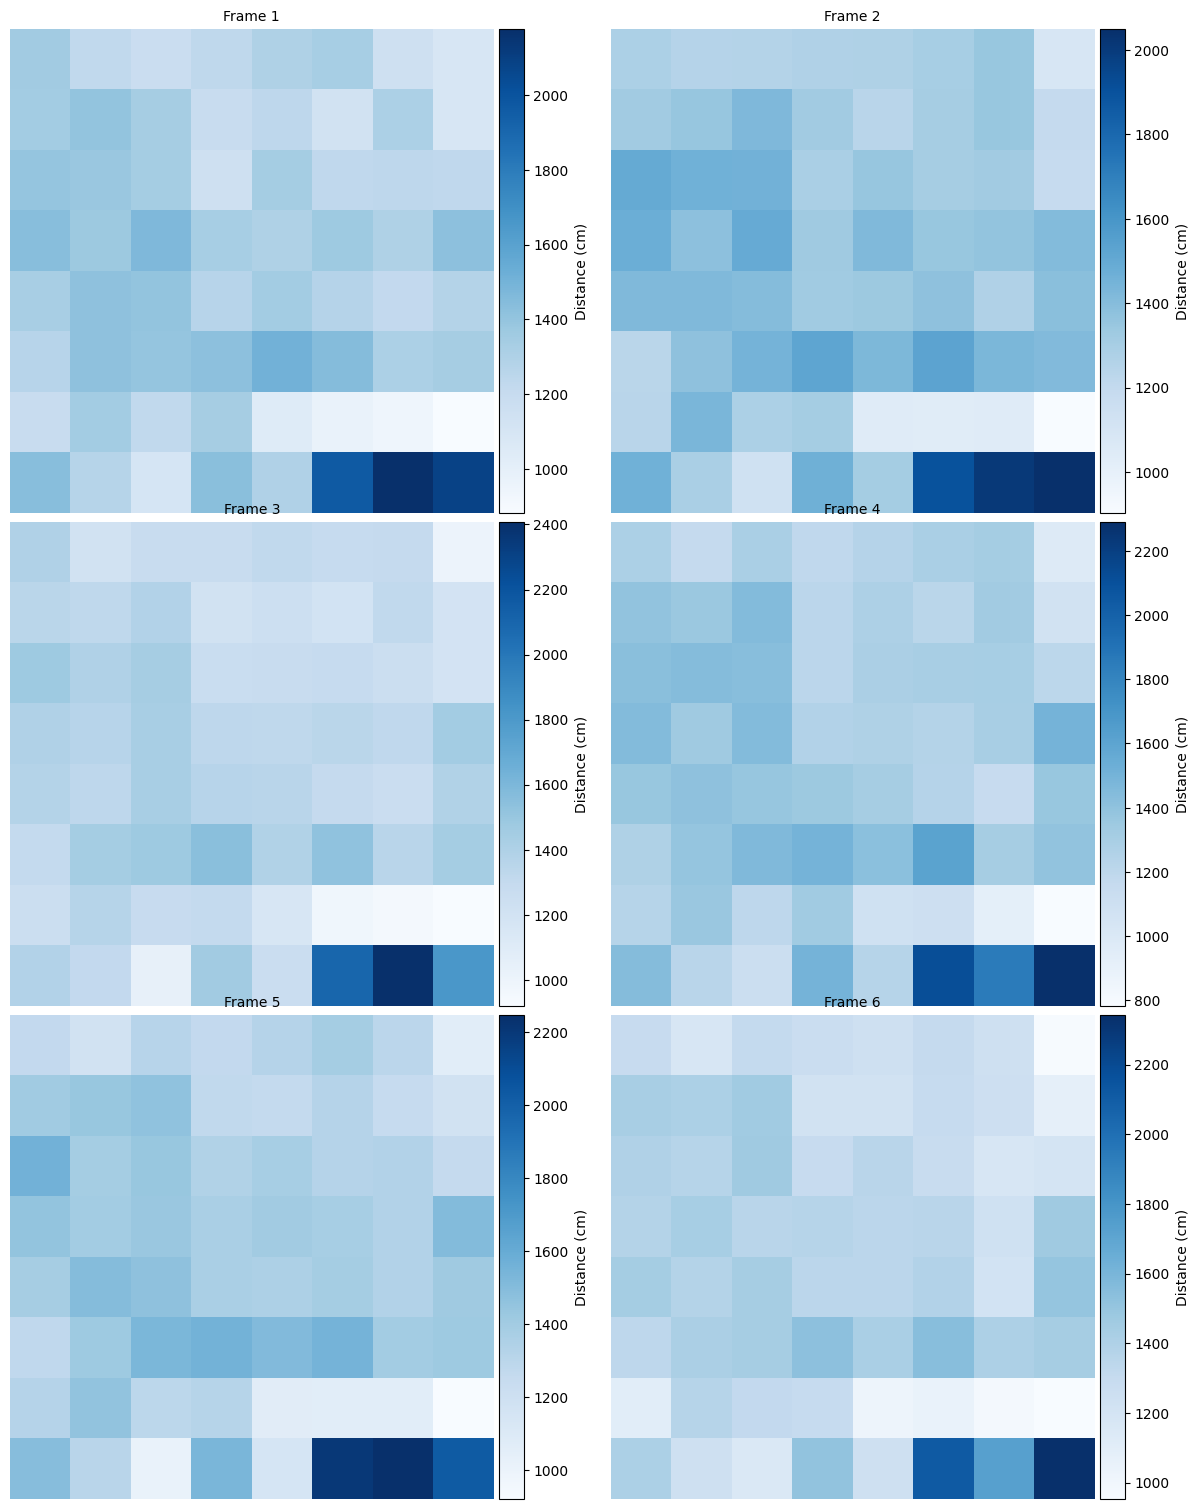

In [183]:
import numpy as np
import matplotlib.pyplot as plt

# load and slice your data
data = np.load(r'D:\AUNUUN JEFFRY MAHBUUBI\PROJECT AND RESEARCH\PROJECTS\28. Depth Camera\CODE\DEPTH CAMERA\Orbbec Gemini 2XL\REMOTE\DEVELOPMENT\notebook\lidar_data.npy')
distance_data = data[:, 0, :, :]
print(f"Distance data shape: {distance_data.shape}")

# only plot up to six frames
n_plots = min(6, distance_data.shape[0])

# use constrained_layout or manually tweak wspace/hspace
fig, axes = plt.subplots(
    3, 2,
    figsize=(10, 15),
    gridspec_kw={'wspace': 0.02, 'hspace': 0.02}
)
axes = axes.flatten()

for i in range(n_plots):
    ax = axes[i]
    im = ax.imshow(distance_data[i], cmap='Blues', interpolation='nearest')
    ax.set_title(f"Frame {i+1}", fontsize=10)
    ax.axis('off')
    # make colorbar pad very small
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.01, label='Distance (cm)')

# hide unused axes
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

# optional: tighten edges of the whole figure
plt.subplots_adjust(left=0.01, right=1.2, top=0.99, bottom=0.01)
plt.show()
